In [1]:
import numpy as np
import cv2 as cv
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import random
import numpy as np

def train_test_split_scratch(X, y, test_size=0.2, random_state=None, stratify=None):

    if random_state is not None:
        random.seed(random_state)

    n_samples = len(X)
    n_test = int(n_samples * test_size)
    n_train = n_samples - n_test


    if stratify is not None:
        # Stratified Splitting
        unique_labels = np.unique(stratify)
        train_indices = []
        test_indices = []

        for label in unique_labels:
            label_indices = np.where(stratify == label)[0]  # Get indices for each label
            n_test_label = int(len(label_indices) * test_size)
            n_train_label = len(label_indices) - n_test_label

            # Shuffle within each label
            random.shuffle(label_indices)
            train_indices.extend(label_indices[:n_train_label])
            test_indices.extend(label_indices[n_train_label:])

        # Shuffle the final indices to maintain randomness within the stratified split
        random.shuffle(train_indices)
        random.shuffle(test_indices)
    else:
         # Random Splitting
        shuffled_indices = list(range(n_samples))
        random.shuffle(shuffled_indices)
        train_indices = shuffled_indices[:n_train]
        test_indices = shuffled_indices[n_train:]



    X_train = [X[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]

    return X_train, X_test, y_train, y_test

In [2]:
# --- Data Loading and Preprocessing ---
dataset_path = "./Data/UCMerced_LandUse/Images" # Replace with your dataset path
categories = os.listdir(dataset_path)
images = []
labels = []

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        img = cv.imread(image_path)
        images.append(img)
        labels.append(i)  # Assign numerical labels

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [3]:
len(X_train)

1680

In [10]:
# --- SIFT Feature Extraction ---
sift = cv.SIFT_create()
descriptors = []
for img in X_train:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    if des is not None:  # Handle cases where no keypoints are detected.
        descriptors.extend(des.astype(np.float32))


In [15]:
len(descriptors[2])
type(descriptors[2][0])

numpy.float32

In [16]:
# Convert the list of descriptors to a NumPy array
descriptors = np.vstack(descriptors)

In [21]:
# --- Building a Visual Vocabulary (Clustering) ---
k = 21 # Number of clusters (visual words) – Adjust as needed
kmeans = KMeans(n_clusters=k, random_state=0).fit(descriptors)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
# --- Quantization and Histogram Representation ---
def create_histogram(image, kmeans):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    if des is None:  # Handle potential issues with images without keypoints.
        return np.zeros(k)  # Return a zero histogram if no descriptors

    histogram = np.zeros(k)
    predictions = kmeans.predict(des)
    for pred in predictions:
        histogram[pred] += 1
    return histogram

X_train_histograms = [create_histogram(img, kmeans) for img in X_train]
X_test_histograms = [create_histogram(img, kmeans) for img in X_test]

Accuracy: 0.55
Confusion Matrix:
[[17  0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0 11  0  1  2  0  1  0  0  0  0  0  0  0  0  0  0  3  1  1  0]
 [ 0  0 10  1  1  0  0  0  0  1  0  0  0  1  1  0  0  1  1  1  2]
 [ 0  0  2 11  0  0  0  1  0  0  0  1  0  0  0  0  4  1  0  0  0]
 [ 0  2  1  0 11  0  4  0  0  0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  0  0 19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  2  0 11  0  0  0  0  0  2  2  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  8  0  0  1  0  0  5  0  1  1  1  1  1]
 [ 0  0  6  1  0  0  1  1  0  5  0  1  0  2  0  1  0  0  1  1  0]
 [ 0  0  0  0  0  0  2  0  0  0 10  2  1  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  0  2  0  0 13  0  0  0  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  7  3  0  0  1  0  3  1  1]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  5 12  0  0  1  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  2  0  0  0  0  0

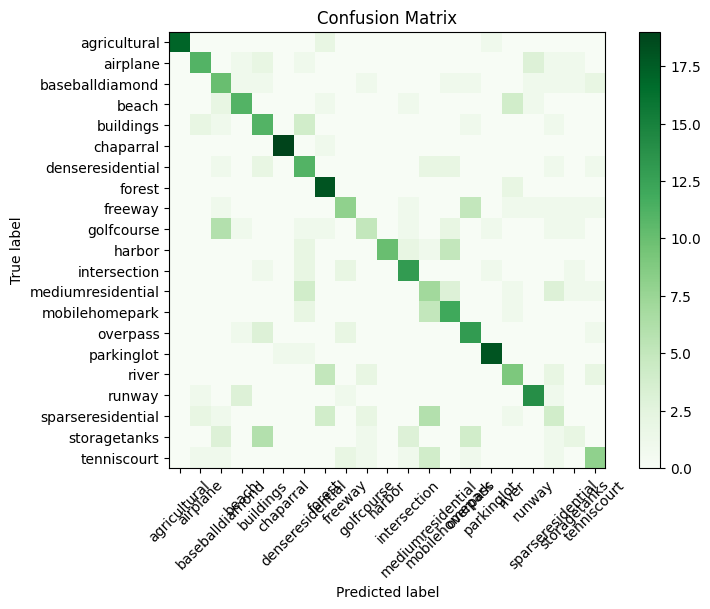

In [26]:

# --- Normalization (L2) ---
X_train_normalized = normalize(X_train_histograms, norm='l2')
X_test_normalized = normalize(X_test_histograms, norm='l2')



# --- Classifier Training (SVM) ---
svm = SVC(kernel='linear', C=1)  # Experiment with different kernels and C values.
svm.fit(X_train_normalized, y_train)




# --- Generate Predictions ---
y_pred = svm.predict(X_test_normalized)


# --- Performance Evaluation ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# --- Visualization of Confusion Matrix (Optional) ---
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()